#### imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, concatenate, Conv2DTranspose,
                                     Dropout, Input, BatchNormalization, Activation, UpSampling2D,
                                     Add, Lambda)

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

from google.colab import drive

In [2]:
def plot_loss(history, title='Training and Validation Loss'):
    try:
        epochs = range(1, len(history.history['loss']) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['loss'], label='Training Loss')
        plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    except KeyError:
        print("Loss data not found in history object.")


def plot_accuracy(history, title='Training and Validation Accuracy'):
    try:
        epochs = range(1, len(history.history['accuracy']) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
    except KeyError:
        print("Accuracy data not found in history object.")


def plot_learning_rate(history, title='Learning Rate Over Epochs'):
    try:
        epochs = range(1, len(history.history['lr']) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['lr'], label='Learning Rate')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.show()
    except KeyError:
        print("Learning rate data not found in history object.")

def plot_iou(history, title='Training and Validation IoU'):
    try:
        epochs = range(1, len(history.history['iou']) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['iou'], label='Training IoU')
        plt.plot(epochs, history.history['val_iou'], label='Validation IoU')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('IoU')
        plt.legend()
        plt.show()
    except KeyError:
        print("IoU data not found in history object.")

def plot_pixel_accuracy(history, title='Training and Validation Pixel Accuracy'):
    try:
        epochs = range(1, len(history.history['pixel_accuracy']) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['pixel_accuracy'], label='Training Pixel Accuracy')
        plt.plot(epochs, history.history['val_pixel_accuracy'], label='Validation Pixel Accuracy')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('Pixel Accuracy')
        plt.legend()
        plt.show()
    except KeyError:
        print("Pixel Accuracy data not found in history object.")

def plot_f1(history, title='Training and Validation F1 Score'):
    try:
        epochs = range(1, len(history.history['f1']) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history.history['f1'], label='Training F1 Score')
        plt.plot(epochs, history.history['val_f1'], label='Validation F1 Score')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.show()
    except KeyError:
        print("F1 Score data not found in history object.")


def summary_table(history):
    try:
        data = {
            'Metric': ['Max Accuracy', 'Min Loss', 'Max IoU', 'Max F1 Score', 'Max Pixel Accuracy'],
            'Training': [
                max(history.history.get('accuracy', [])),
                min(history.history.get('loss', [])),
                max(history.history.get('iou', [])),
                max(history.history.get('f1', [])),
                max(history.history.get('pixel_accuracy', []))
            ],
            'Validation': [
                max(history.history.get('val_accuracy', [])),
                min(history.history.get('val_loss', [])),
                max(history.history.get('val_iou', [])),
                max(history.history.get('val_f1', [])),
                max(history.history.get('val_pixel_accuracy', []))
            ]
        }

        df = pd.DataFrame(data)
        return df
    except KeyError as e:
        print(f"Error in history data: {e}")

def iou(y_true, y_pred):
    def f(args):
        y_true, y_pred = args
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
        return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())
    return tf.reduce_mean(tf.map_fn(f, (y_true, y_pred), dtype=tf.float32))


def f1(y_true, y_pred):
    def f(args):
        y_true, y_pred = args
        precision = tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
        recall = tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(tf.map_fn(f, (y_true, y_pred), dtype=tf.float32))


def pixel_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.round(y_true), tf.round(y_pred)), tf.float32))


In [3]:
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/Colab Notebooks/deep_learning_exam/'


def load_and_preprocess_image(path, target_size=(256, 256)):
    img = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.cast(img_array, tf.float32) / 255.0  # Normalize to 0 and 1
    return img_array

def load_images_from_folder(folder, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img_array = load_and_preprocess_image(img_path, target_size)
        images.append(img_array)
    return np.array(images)

train_images = load_images_from_folder(os.path.join(folder_path, 'train/images'))
test_images = load_images_from_folder(os.path.join(folder_path, 'test/images'))

def load_and_preprocess_mask(path, target_size=(256, 256)):
    mask = tf.keras.preprocessing.image.load_img(path, target_size=target_size, color_mode='grayscale')
    mask_array = tf.keras.preprocessing.image.img_to_array(mask)
    mask_array = tf.cast(mask_array, tf.float32) / 255.0  #0 and 1
    return mask_array

def load_masks_from_folder(folder, target_size=(256, 256)):
    masks = []
    for filename in os.listdir(folder):
        mask_path = os.path.join(folder, filename)
        mask_array = load_and_preprocess_mask(mask_path, target_size)
        masks.append(mask_array)
    return np.array(masks)

train_masks = load_masks_from_folder(os.path.join(folder_path, 'train/masks'))
test_masks = load_masks_from_folder(os.path.join(folder_path, 'test/masks'))

train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

#checking if there is gpu
print(tf.config.list_physical_devices('GPU'))

Mounted at /content/drive
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### U-Net

Epoch 1/100
12/12 [==============================] - 10s 305ms/step - loss: 0.5077 - accuracy: 0.7871 - iou: 0.0621 - f1: 0.1138 - pixel_accuracy: 0.7898 - val_loss: 0.3983 - val_accuracy: 0.8937 - val_iou: 0.0730 - val_f1: 0.1315 - val_pixel_accuracy: 0.8928 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - 3s 249ms/step - loss: 0.3085 - accuracy: 0.9023 - iou: 0.0874 - f1: 0.1549 - pixel_accuracy: 0.9022 - val_loss: 0.4374 - val_accuracy: 0.8937 - val_iou: 0.0688 - val_f1: 0.1234 - val_pixel_accuracy: 0.8928 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - 3s 243ms/step - loss: 0.2774 - accuracy: 0.9042 - iou: 0.1017 - f1: 0.1765 - pixel_accuracy: 0.9041 - val_loss: 0.4447 - val_accuracy: 0.8937 - val_iou: 0.0637 - val_f1: 0.1156 - val_pixel_accuracy: 0.8928 - lr: 0.0010
Epoch 4/100
12/12 [==============================] - 3s 267ms/step - loss: 0.2717 - accuracy: 0.9042 - iou: 0.1186 - f1: 0.2007 - pixel_accuracy: 0.9042 - val_loss: 0.3957 - val_accur

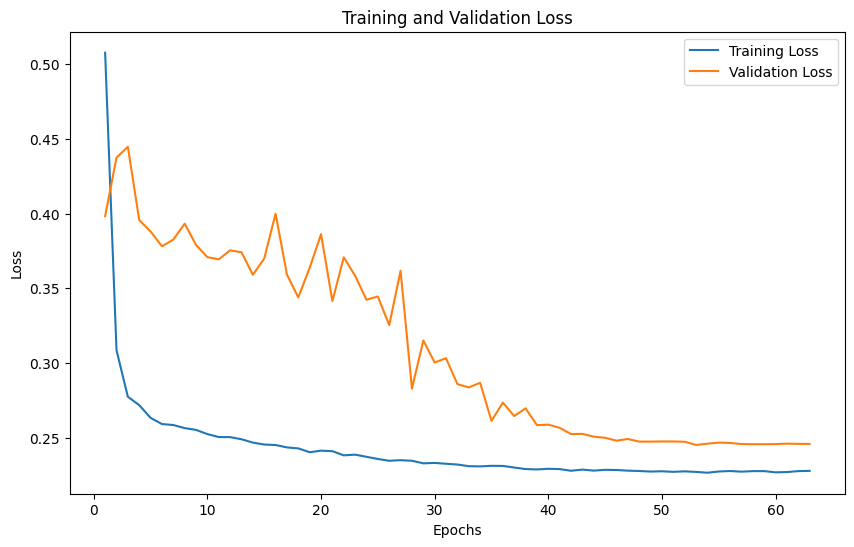

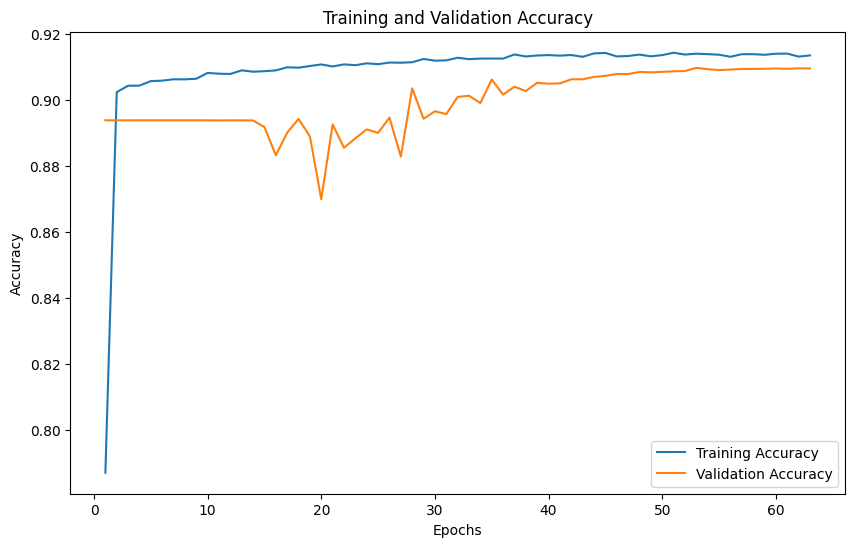

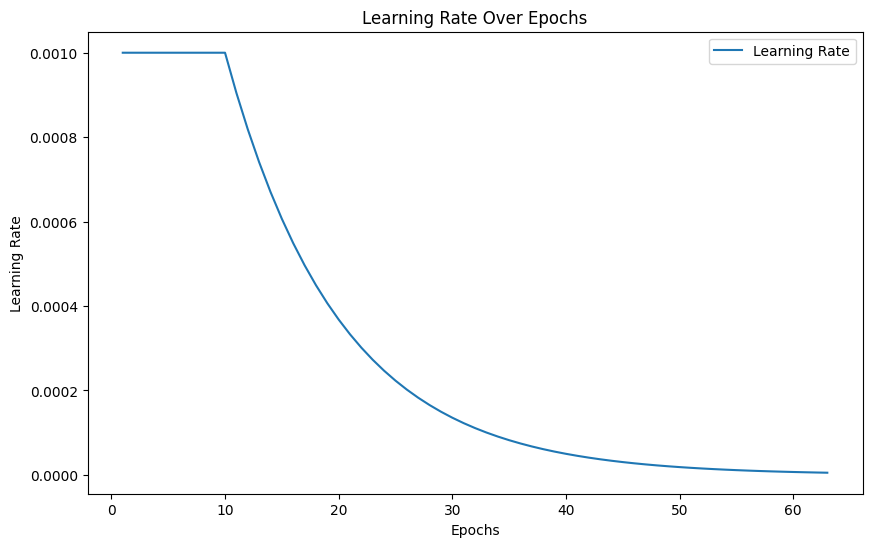

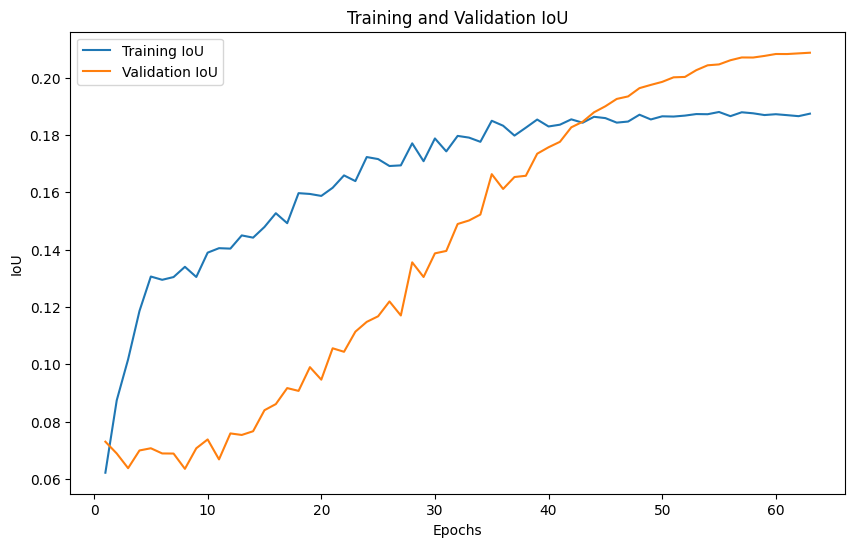

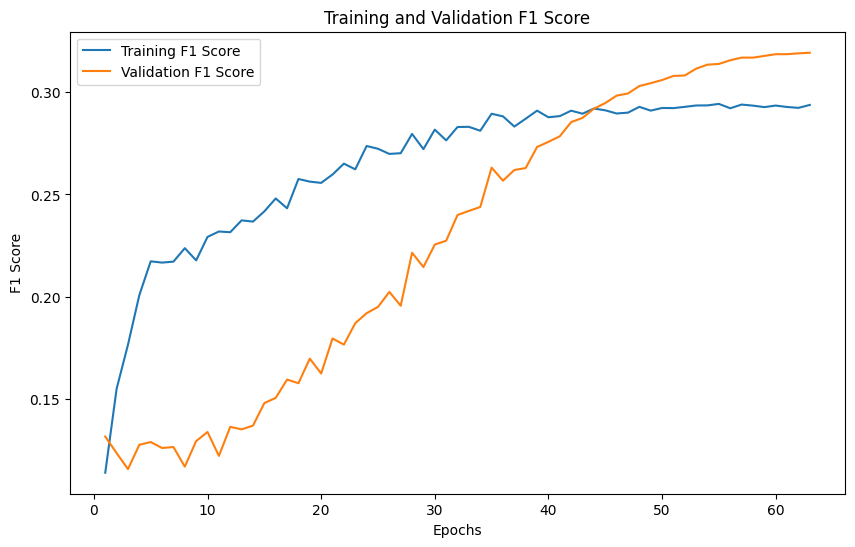

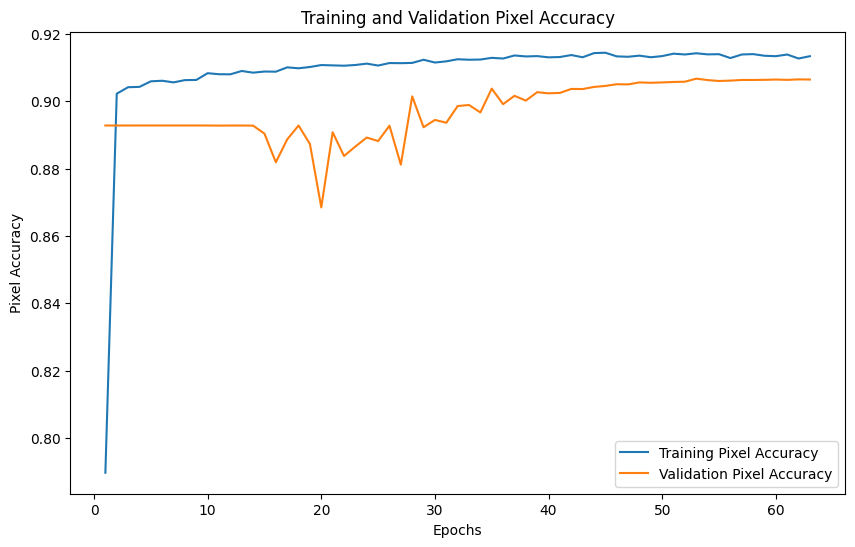

               Metric  Training  Validation
0        Max Accuracy  0.914185    0.909604
1            Min Loss  0.226500    0.245097
2             Max IoU  0.188006    0.208685
3        Max F1 Score  0.294325    0.319384
4  Max Pixel Accuracy  0.914343    0.906649


In [9]:
#Unet

def unet_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.3)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    u4 = BatchNormalization()(u4)
    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1], axis=3)
    u5 = BatchNormalization()(u5)
    c5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (256, 256, 3)
model = unet_model(input_shape)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001)
callbacks = [LearningRateScheduler(scheduler), early_stopping]

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', iou, f1, pixel_accuracy])

history = model.fit(train_images, train_masks, validation_data=(test_images, test_masks),
                    batch_size=32, epochs=100, callbacks=callbacks)


#visuals
plot_loss(history)
plot_accuracy(history)
plot_learning_rate(history)
plot_iou(history)
plot_f1(history)
plot_pixel_accuracy(history)
print(summary_table(history))


#### U-Net plus plus

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.4834 - accuracy: 0.8241 - iou: 0.1017 - f1: 0.1780 - pixel_accuracy: 0.8251
Epoch 1: val_accuracy improved from -inf to 0.13046, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 24s 852ms/step - loss: 0.4834 - accuracy: 0.8241 - iou: 0.1017 - f1: 0.1780 - pixel_accuracy: 0.8251 - val_loss: 2.0106 - val_accuracy: 0.1305 - val_iou: 0.1088 - val_f1: 0.1894 - val_pixel_accuracy: 0.1305 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.9031 - iou: 0.1102 - f1: 0.1903 - pixel_accuracy: 0.9029
Epoch 2: val_accuracy did not improve from 0.13046
12/12 [==============================] - 4s 317ms/step - loss: 0.3152 - accuracy: 0.9031 - iou: 0.1102 - f1: 0.1903 - pixel_accuracy: 0.9029 - val_loss: 13.9277 - val_accuracy: 0.1190 - val_iou: 0.1079 - val_f1: 0.1879 - val_pixel_accuracy: 0.1190 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.9047 - iou: 0.1269 - f1: 0.2128 - pixel_accuracy: 0.9044
Epoch 3: val_accuracy did not improve from 0.13046
12/12 [==============================] - 3s 265ms/step - loss: 0.2845 - accuracy: 

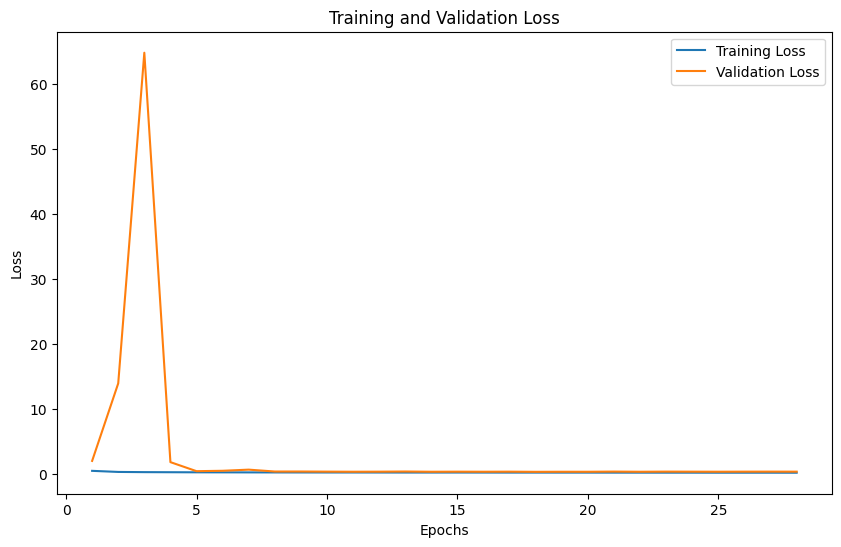

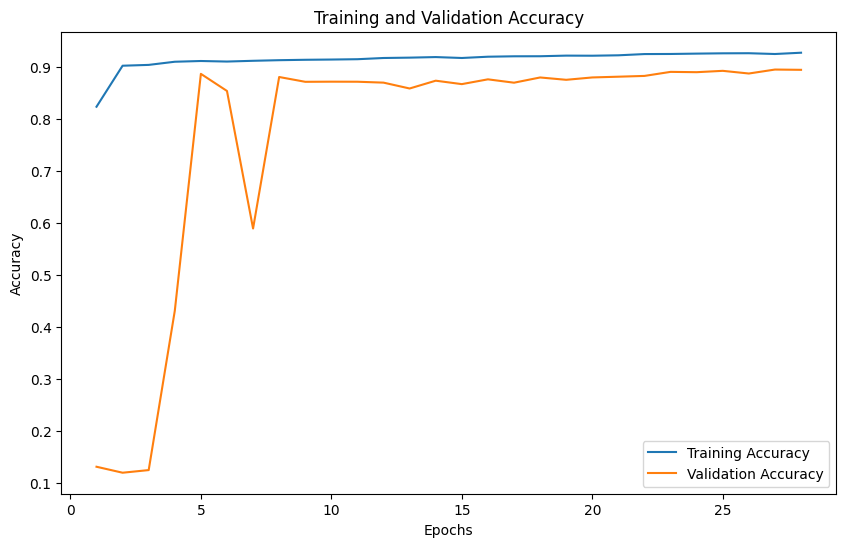

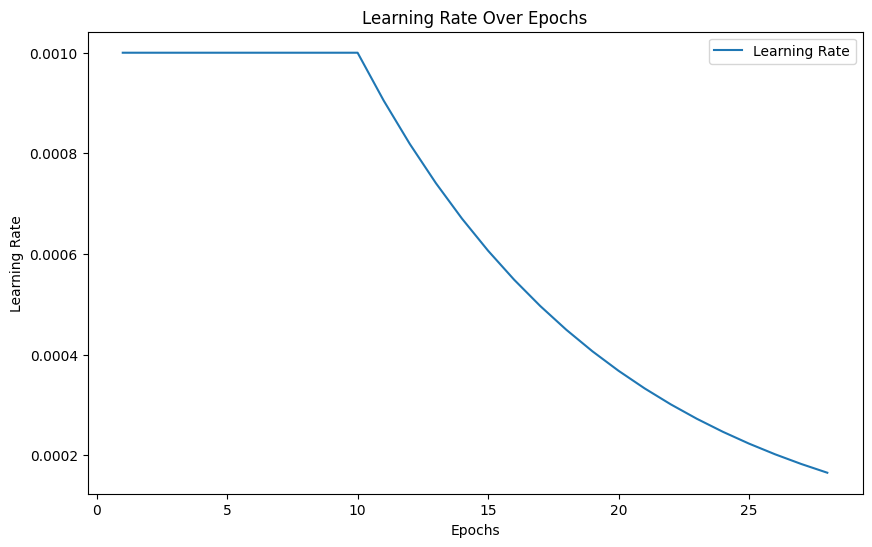

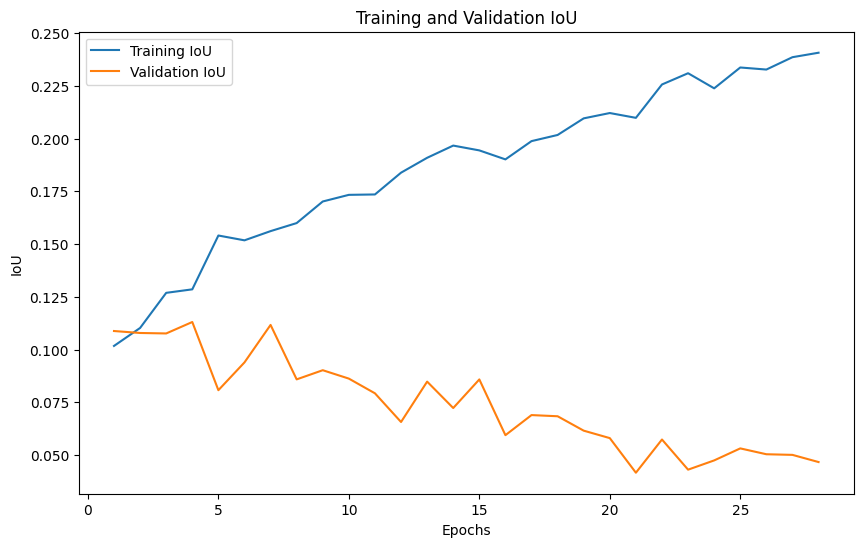

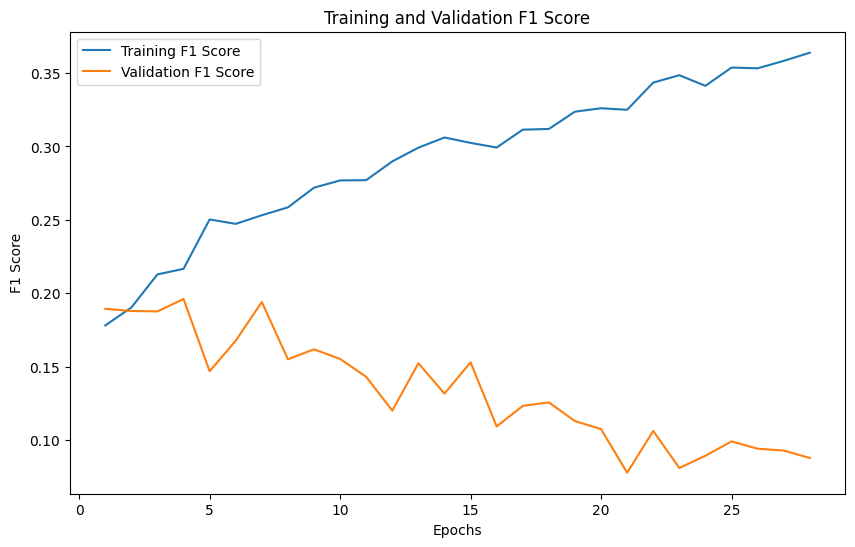

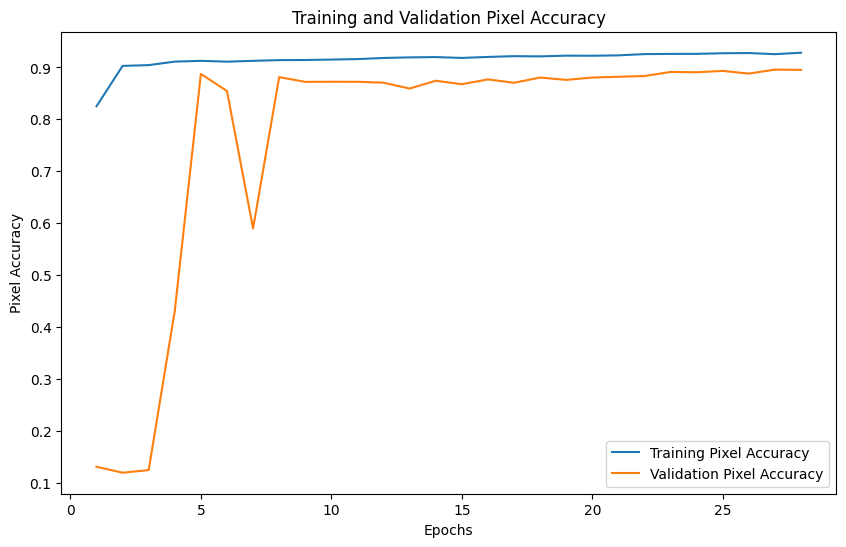

               Metric  Training  Validation
0        Max Accuracy  0.928183    0.895761
1            Min Loss  0.194496    0.332359
2             Max IoU  0.240683    0.113070
3        Max F1 Score  0.363839    0.196068
4  Max Pixel Accuracy  0.928292    0.895720


In [10]:
#UNET ++

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def upsample_concat_block(input_tensor, skip_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = concatenate([x, skip_tensor])
    x = conv_block(x, num_filters)
    return x

def unet_plus_plus(input_shape):
    inputs = Input(input_shape)

    c1 = conv_block(inputs, 32)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 256)
    p4 = MaxPooling2D((2, 2))(c4)

    bn = conv_block(p4, 512)

    u1 = upsample_concat_block(bn, c4, 256)
    u2 = upsample_concat_block(u1, c3, 128)
    u3 = upsample_concat_block(u2, c2, 64)
    u4 = upsample_concat_block(u3, c1, 32)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

model = unet_plus_plus((256, 256, 3))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou, f1, pixel_accuracy])

early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopper, model_checkpoint, lr_scheduler]
)

#visuals
plot_loss(history)
plot_accuracy(history)
plot_learning_rate(history)
plot_iou(history)
plot_f1(history)
plot_pixel_accuracy(history)
print(summary_table(history))



#### FPN

Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.9047 - iou: 0.0701 - f1: 0.1277 - pixel_accuracy: 0.9054
Epoch 1: val_accuracy improved from -inf to 0.89448, saving model to best_model.h5
48/48 [==============================] - 28s 529ms/step - loss: 0.3155 - accuracy: 0.9047 - iou: 0.0701 - f1: 0.1277 - pixel_accuracy: 0.9054 - val_loss: 0.3039 - val_accuracy: 0.8945 - val_iou: 0.0943 - val_f1: 0.1676 - val_pixel_accuracy: 0.8948 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9048 - iou: 0.1007 - f1: 0.1768 - pixel_accuracy: 0.9056
Epoch 2: val_accuracy did not improve from 0.89448
48/48 [==============================] - 24s 493ms/step - loss: 0.2700 - accuracy: 0.9048 - iou: 0.1007 - f1: 0.1768 - pixel_accuracy: 0.9056 - val_loss: 0.2999 - val_accuracy: 0.8945 - val_iou: 0.1080 - val_f1: 0.1886 - val_pixel_accuracy: 0.8948 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.9048 - iou: 0.1096 - f1: 0.1893 - pixel_accuracy: 0.9056
Epoch 3: val_accuracy did not improve from 0.89448
48/48 [==============================] - 23s 488ms/step - loss: 0.2649 - accuracy: 0.9048 - iou: 0.1096 - f1: 0.1893 - pixel_accuracy: 0.9056 - val_loss: 0.2992 - val_accuracy: 0.8945 - val_iou: 0.1051 - val_f1: 0.1842 - val_pixel_accuracy: 0.8948 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9048

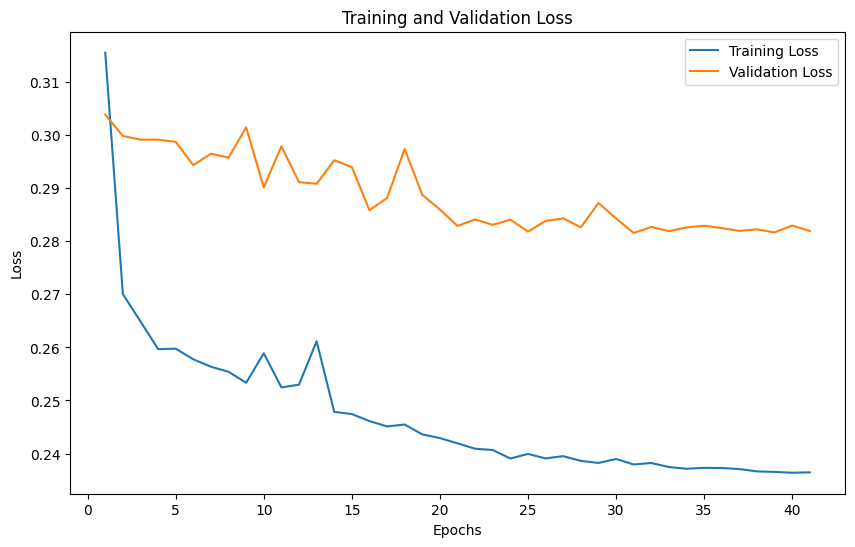

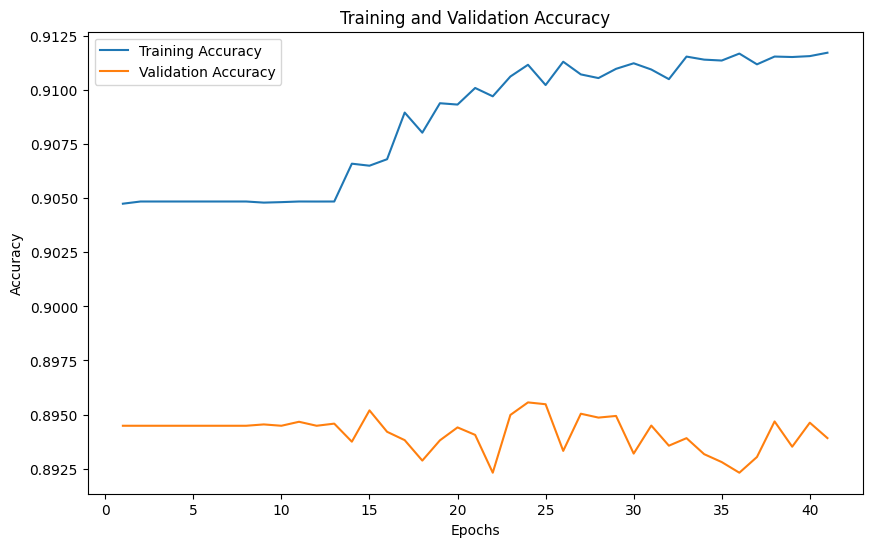

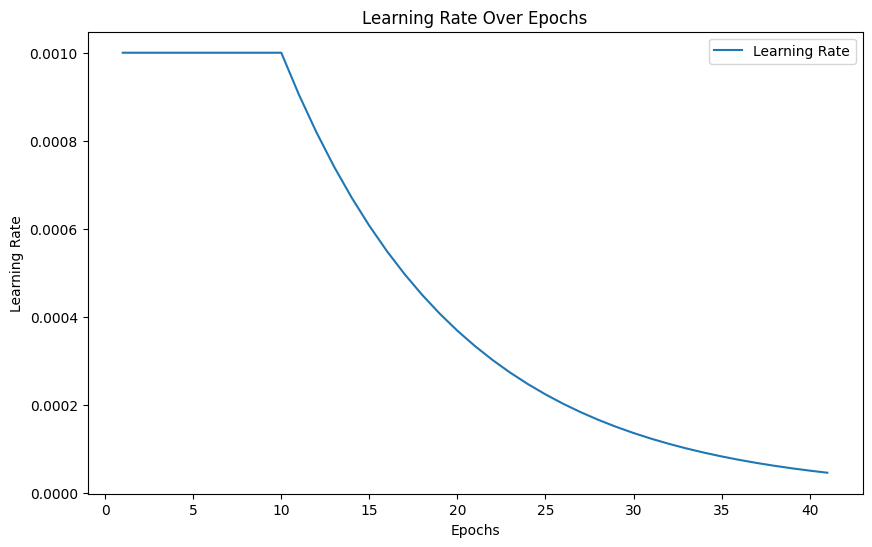

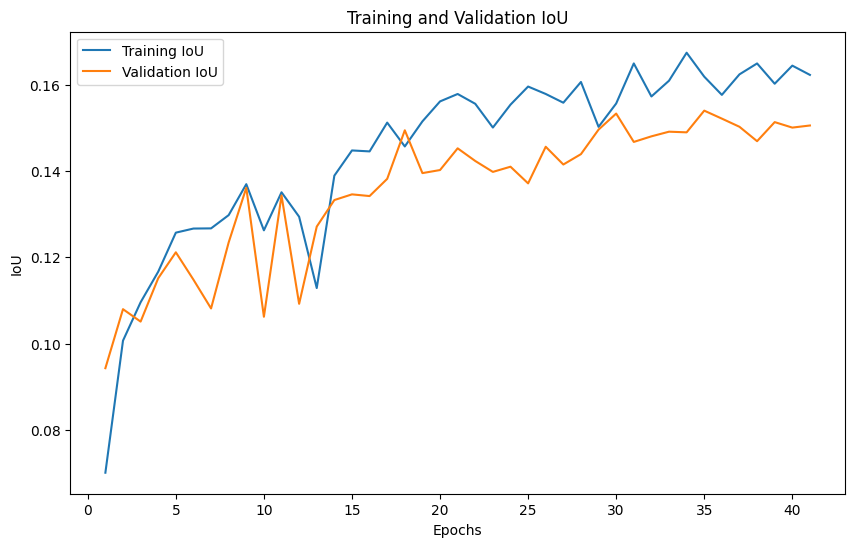

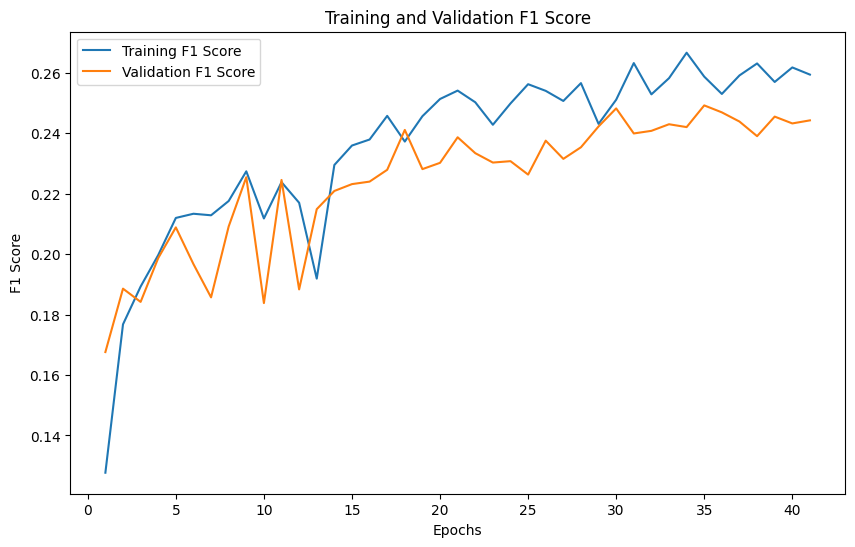

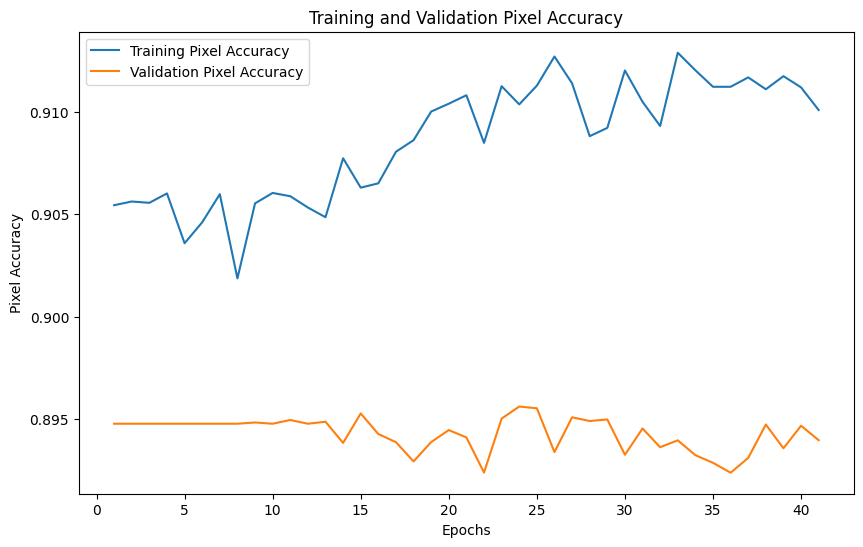

               Metric  Training  Validation
0        Max Accuracy  0.911725    0.895563
1            Min Loss  0.236381    0.281555
2             Max IoU  0.167463    0.154031
3        Max F1 Score  0.266627    0.249200
4  Max Pixel Accuracy  0.912887    0.895617


In [11]:
def resize_image(tensor, size):
    return tf.image.resize(tensor, size)

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    return x

def create_fpn(input_shape, num_classes):
    inputs = Input(input_shape)

    conv1 = conv_block(inputs, 16)
    conv2 = conv_block(conv1, 32)
    p3 = conv_block(conv2, 64)
    p4 = conv_block(p3, 128)
    p5 = conv_block(p4, 128)

    p4_adjusted = conv_block(p4, 128)
    p3_adjusted = conv_block(p3, 128)

    up_p4 = UpSampling2D(size=(2, 2))(p5)
    up_p4 = resize_image(up_p4, tf.shape(p4_adjusted)[1:3])
    up_p4 = Add()([up_p4, p4_adjusted])

    up_p3 = UpSampling2D(size=(2, 2))(up_p4)
    up_p3 = resize_image(up_p3, tf.shape(p3_adjusted)[1:3])
    up_p3 = Add()([up_p3, p3_adjusted])

    up_final = UpSampling2D(size=(2, 2))(up_p3)
    up_final = resize_image(up_final, input_shape[:2])

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up_final)

    model = Model(inputs, outputs)
    return model

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

fpn_model = create_fpn(input_shape=(256, 256, 3), num_classes=2)

fpn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', iou, f1, pixel_accuracy])

early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
lr_scheduler = LearningRateScheduler(scheduler)

history = fpn_model.fit(
    x=train_images,
    y=train_masks,
    validation_data=(val_images, val_masks),
    batch_size=8,
    epochs=100,
    callbacks=[early_stopper, model_checkpoint, lr_scheduler]
)

#visuals
plot_loss(history)
plot_accuracy(history)
plot_learning_rate(history)
plot_iou(history)
plot_f1(history)
plot_pixel_accuracy(history)
print(summary_table(history))